In [1]:
%%HTML
<style> code {background-color : pink !important;} </style>

Advanced Lane Lines
===


In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
chess_grid_width = 9
chess_grid_height = 6

## load calibration matrix and distortion coefficients

In [3]:
import pickle
wide_dist_pickle_file = "./calibration_wide/wide_dist_pickle.p"
with open(wide_dist_pickle_file, mode='rb') as f:
    mtx_dist = pickle.load(f)

mtx, dist = mtx_dist['mtx'], mtx_dist['dist']

In [4]:
def undistort(img, mtx, dist):
    img_size = (img.shape[1], img.shape[0])
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst
    
def unwarp(image, src_corners, dst_corners):
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    # use cv2.warpPerspective() to warp image to a top-down view
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return warped, M, Minv


## undistort image

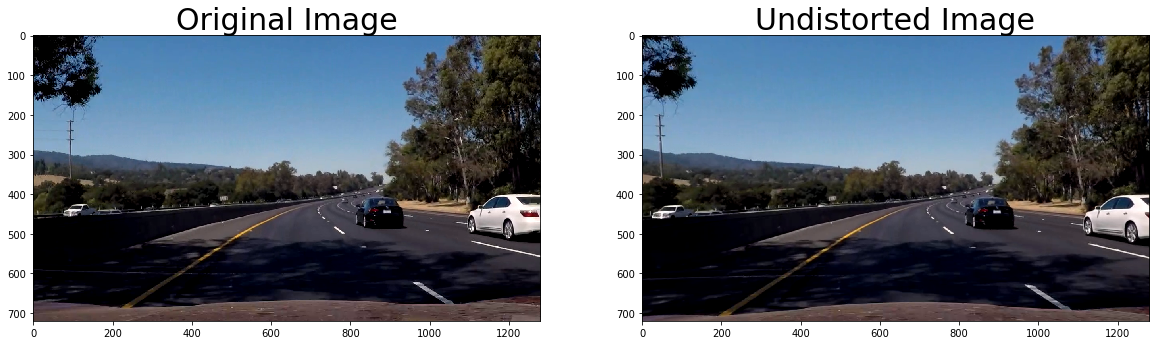

In [5]:
%matplotlib inline
img = cv2.imread('test_images/hard3.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
nx = chess_grid_width # the number of inside corners in x
ny = chess_grid_height # the number of inside corners in y

undist = undistort(img, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)


img = undist

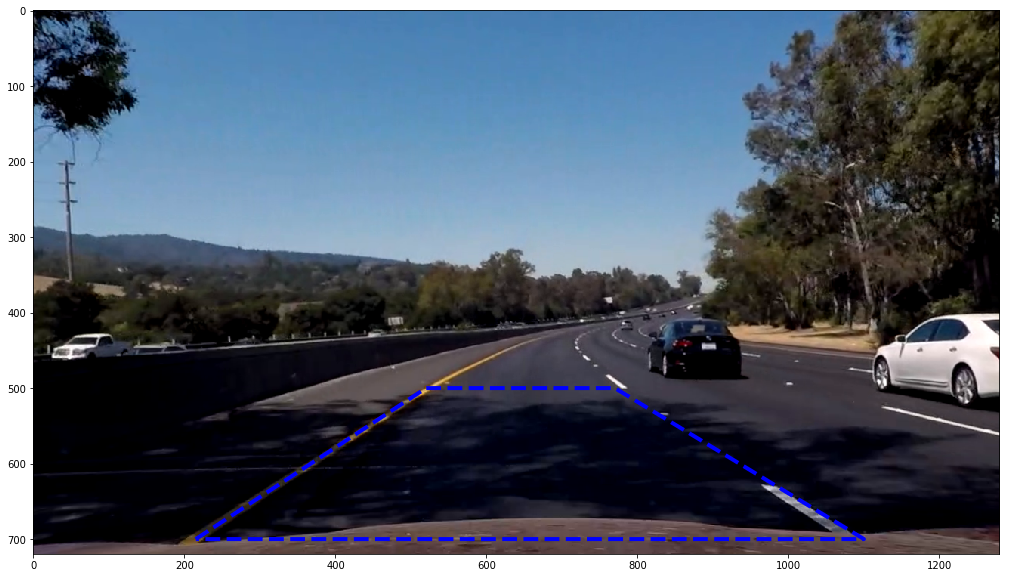

In [6]:
left_bottom = [215,700]
left_top = [520,500]
right_top = [770,500]
right_bottom = [1100,700]
src = np.float32([left_top,right_top,left_bottom,right_bottom])
# Source coordinates
image_width = img.shape[1]
image_height = img.shape[0]
src = np.float32([
        [image_width * 0.4475, image_height * 0.65],
        [image_width * 0.5525, image_height * 0.65],
        [image_width * 0.175, image_height * 0.95],
        [image_width * 0.825, image_height * 0.95],
    ])

# Destination coordinates
dst = np.float32([
        [image_width * 0.2, image_height * 0.025],
        [image_width * 0.8, image_height * 0.025],
        [image_width * 0.2, image_height * 0.975],
        [image_width * 0.8, image_height * 0.975],
    ])

x = [left_bottom[0], left_top[0], right_top[0], right_bottom[0], left_bottom[0]]
y = [left_bottom[1], left_top[1], right_top[1], right_bottom[1], left_bottom[1]]
plt.figure(figsize=(20,10))
plt.plot(x, y, 'b--', lw=4)
plt.imshow(img)
plt.show()
    # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
# dst = np.float32([[100,500],[1200,500],[100,700],[1200,700]])

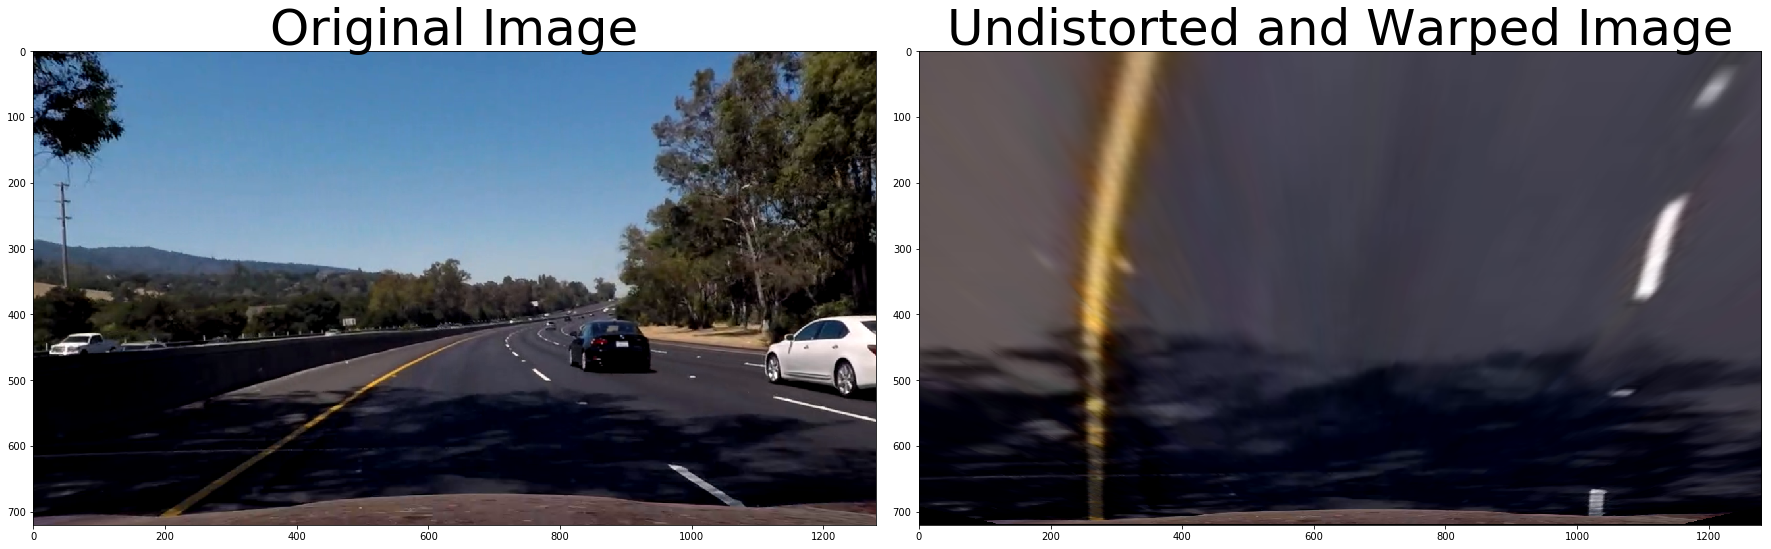

In [7]:
top_down, perspective_M, Minv = unwarp(img, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [42]:
def threshold(img):
    """Threshhold image on saturation channel and 
    using magnitude gradient"""
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    
    
    ## White Color
    lower_white = np.array([0,210,0], dtype=np.uint8)
    upper_white = np.array([255,255,255], dtype=np.uint8)
    white_mask = cv2.inRange(hls, lower_white, upper_white)
    
    ## Yellow Color
    lower_yellow = np.array([18,0,100], dtype=np.uint8)
    upper_yellow = np.array([30,220,255], dtype=np.uint8)
    yellow_mask = cv2.inRange(hls, lower_yellow, upper_yellow)  
    
    combined_binary = np.zeros_like(white_mask)
    
    combined_binary[((white_mask == 255) | (yellow_mask == 255))] = 255
    combined_binary[(combined_binary == 255)] = 1
    return combined_binary


In [43]:


def f(s_max,s_min,sx_max,sx_min):
    cb = threshold(top_down)
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(top_down)
    ax1.set_title('Original Image', fontsize=40)

    # print(resultc
    ax2.imshow(cb)
    ax2.set_title('Binary Image', fontsize=40)
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
# # s_thresh=(30, 255), sx_thresh=(150, 255)
# interact(f, s_max=(100,255,1), s_min=(0,200,1), sx_max=(100,255,1), sx_min=(0,100,1))
# # straight1 228 70 168 26
# # test1 226 90 213 93
# # 177 50 177 50
# # 177 97 177 85

360


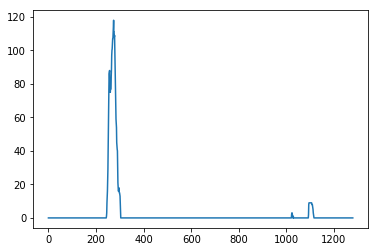

In [44]:
# s_min = 50
# s_max = 177
# sx_min = 28
# sx_max = 177
s_min = 100
s_max = 177
sx_min = 85
sx_max = 177

# binary_img, combined_binary = pipeline(top_down, s_thresh=(s_min, s_max), sx_thresh=(sx_min, sx_max))
combined_binary = threshold(top_down)
histogram = np.sum(combined_binary[combined_binary.shape[0]//2:,:], axis=0)
plt.plot(histogram)

aa = combined_binary.shape[0]//2
print(aa)

# solution 2

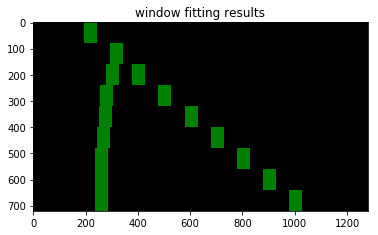

In [45]:
warped = combined_binary

# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()


In [46]:
def find_base(combined_binary):
    binary_warped = combined_binary
    # Create an output image to draw on and  visualize the result
#     out_img = np.dstack((combined_binary, combined_binary, combined_binary))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

#     print('leftx_base')
#     print(leftx_base)
#     print('rightx_base')
#     print(rightx_base)
    return leftx_base, rightx_base

leftx_base, rightx_base = find_base(combined_binary)


(720, 0)

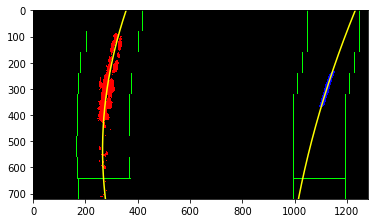

In [47]:
def find_polyfit(warped, leftx_base, rightx_base, out_img=None):
    binary_warped = warped
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if out_img is not None:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    #     print('good_left,right idx: {} {}'.format(good_left_inds,good_right_inds))
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    if lefty.size is 0 or leftx.size is 0:
        # Display the final results
        plt.imshow(warped)
        plt.title('window fitting results')
        plt.show()
        print('aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa')
        return

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds

out_img = np.dstack((combined_binary, combined_binary, combined_binary))*255
left_fit, right_fit, left_lane_inds, right_lane_inds = find_polyfit(combined_binary, leftx_base, rightx_base, out_img)
# Generate x and y values for plotting
ploty = np.linspace(0, combined_binary.shape[0]-1, combined_binary.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

nonzero = combined_binary.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

# Measuring Curvature

In [48]:
# Calculates curvature given lane polynomial fit and bottom vertical point
def get_curvature(left_fit,right_fit, y_eval):
    ym_per_pix = 3.0/72.0 # meters per pixel in y dimension
    xm_per_pix = 3.7/660.0 # meters per pixel in x dimension
    y_eval = 700
    

    y1 = (2*left_fit[0]*y_eval + left_fit[1])*xm_per_pix/ym_per_pix
    y2 = 2*left_fit[0]*xm_per_pix/(ym_per_pix*ym_per_pix)

    curvature = ((1 + y1*y1)**(1.5))/np.absolute(y2)
    
    midx = 650
    x_left_pix = left_fit[0]*(y_eval**2) + left_fit[1]*y_eval + left_fit[2]
    x_right_pix = right_fit[0]*(y_eval**2) + right_fit[1]*y_eval + right_fit[2]
#     print(x_left_pix)
#     print(x_right_pix)
    position_from_center = ((x_left_pix + x_right_pix)/2 - midx) * xm_per_pix
    
    return curvature, position_from_center

yvalue = combined_binary.shape[0]
c = get_curvature(left_fit,right_fit, yvalue)
print('cccccccc: {}'.format(c))

cccccccc: (490.9644033090014, -0.019386623257994829)


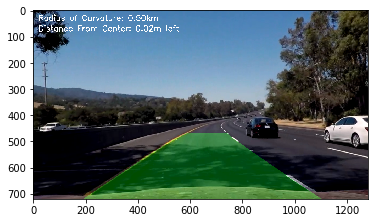

In [49]:
def draw_lane_area(warped, undist, left_fit, right_fit):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    yvalue = 700 # warped.shape[0]
    curvature,distance = get_curvature(left_fit,right_fit, yvalue)
    curvature = round(curvature/1000,1)
    s = str('radius of curvature: '+str(curvature)+'km')
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,'Radius of Curvature: %.2fkm' % curvature,(20,40), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)

    if distance < 0:
        text = 'left'
    else:
        text = 'right'
    cv2.putText(result,'Distance From Center: %.2fm %s' % (np.absolute(distance), text),(20,80), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    
    return result

result = draw_lane_area(combined_binary, undist, left_fit, right_fit)
plt.imshow(result)

In [40]:
def process_image(image):
    undist_img = undistort(image, mtx, dist)
    bird_view, perspective_M, Minv = unwarp(undist_img, mtx, dist)
    s_min = 100
    s_max = 177
    sx_min = 85
    sx_max = 177

#     binary_img_sep, com_img = pipeline(bird_view, s_thresh=(s_min, s_max), sx_thresh=(sx_min, sx_max))
    com_img = threshold(bird_view)
    left_x_base, right_x_base = find_base(com_img)
    left_polyfit, right_polyfit,_,_ = find_polyfit(com_img, left_x_base, right_x_base)
#     # Generate x and y values for plotting
#     ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
#     left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#     right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    result = draw_lane_area(com_img, undist_img, left_polyfit, right_polyfit)
    return result

In [41]:
white_output = 'output_videos/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [01:13<00:00, 17.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

CPU times: user 1min 48s, sys: 2.77 s, total: 1min 51s
Wall time: 1min 14s
